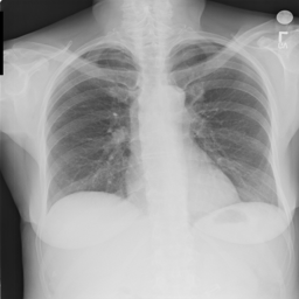

In [283]:
import numpy as np
import tensorflow as tf
import keras

import os
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

img_size = (128, 128)

# The local path to our target image
img_path = "covid xray/test/COVID/COVID-2032.png"
img_path = "covid xray/test/NORMAL/NORMAL-2030.png"
display(Image(img_path))

In [ ]:
loaded_model = tf.keras.models.load_model('covid_xray_model.h5')  # Load the model
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (1, 126, 126, 64)      │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (1, 63, 63, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (1, 63, 63, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 61, 61, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (1, 30, 30, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 57600)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 64)                │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,725,507 (14.21 MB)

 Trainable params: 3,725,377 (14.21 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2 (12.00 B)

### Redefine model so I have different output layer -> shape (1,1000)

- We have to change the last layer to not have a scalar as output
- I here redefined the model completely because in task 2 I made it with sequential() and then it doesn't work for some reason

In [211]:
from tensorflow.keras import datasets, layers, models
METRICS = ["accuracy"]
# constants
img_height = img_width = 128
batch_size = 128
img_size = (img_height, img_width)

train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'
epochs = 30

full_data_gen = training_data_Pipeline(128, img_size, 'covid xray/train_val')
val_data_gen = test_validation_data_Pipeline(batch_size, img_size, test_dir=val_dir, train_dir=train_dir)

total_train = full_data_gen.samples
total_val = val_data_gen.samples

learning_rate = 0.001
dropout_rate = 0.3
filters = 32
optimizer = 'sgd'

inputs = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', name="last_conv")(x)  # <-- Name this layer for Grad-CAM
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1000)(x)  # from_logits=True will handle this

redefined_model = Model(inputs, outputs)

redefined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

redefined_model.summary()

history = redefined_model.fit(
    full_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


Model: "functional_228"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1000)           │        65,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,918,536 (7.32 MB)

 Trainable params: 1,918,472 (7.32 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 909ms/step - accuracy: 0.4112 - loss: 2.9054 - val_accuracy: 0.5599 - val_loss: 1.1694
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6797 - loss: 0.6268 - val_accuracy: 0.5625 - val_loss: 1.0833
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 904ms/step - accuracy: 0.7209 - loss: 0.6397 - val_accuracy: 0.5833 - val_loss: 0.9717
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.4457 - val_accuracy: 0.4375 - val_loss: 0.9019
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 873ms/step - accuracy: 0.7873 - loss: 0.4802 - val_accuracy: 0.6589 - val_loss: 0.8533
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.4611 - val_accuracy: 0.5625 - val_loss: 0.8606
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 859ms/step - accuracy: 0.8186 - loss: 0.4368 - val_accuracy: 0.7083 - val_loss: 0.7758
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 0.5098 - val_accuracy: 0.5625

### Functions to get image array and to make Grad-CAM map (from tutorial)

In [ ]:
def get_img_array(img_path, size):

    img = keras.utils.load_img(img_path, target_size=size)

    array = keras.utils.img_to_array(img)

    # We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, sublayer = None, pred_index=None):
    
    if sublayer is None:
        output = model.get_layer(last_conv_layer_name).output
    else:
        output = model.get_layer(last_conv_layer_name).get_layer(sublayer).output

    # First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        
        model.inputs, [output, model.output]
    )

    # We compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        # For binary classification, just get the scalar output ????
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Average the gradients along the spatial dimension to get a proxy for the channel importance
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    #averaging the activations along the channel dimension, weighting each channel according to its importance
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)

    # normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

### grad-CAM for redefined baseline model

Image shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(1, 1000)
[-5.4159017]


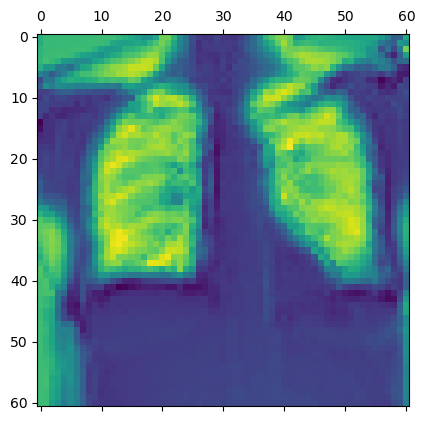

In [325]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

redefined_model.layers[-1].activation = None

# Print what the top predicted class is
preds = redefined_model.predict(img_array)
print(preds.shape)
print(preds[:,3])
heatmap = make_gradcam_heatmap(img_array, redefined_model, "last_conv")

# Display heatmap
plt.matshow(heatmap)
plt.show()


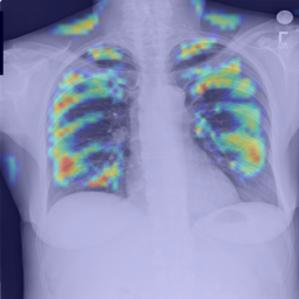

In [326]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, threshold=0.8):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

### Now lets try for Resnet model of task 3

In [272]:
loaded_model = load_model("ResNet_model.h5")
loaded_model.summary()

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

# Get all layers except the last one
x = loaded_model.layers[-2].output  # or however many layers back you want to go
outputs = Dense(1000)(x)

# Create a new model with modified output
new_model = Model(inputs=loaded_model.input, outputs=outputs)

# Compile with new loss (e.g., categorical crossentropy if 1000-class classification)
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     1,048,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,613,443 (93.89 MB)

 Trainable params: 1,048,641 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 2 (12.00 B)

Model: "functional_268"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     1,048,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1000)           │        33,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,646,408 (94.02 MB)

 Trainable params: 1,081,608 (4.13 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [273]:
#last sublayers inside resnet
print(new_model.get_layer("resnet50v2").layers[-1].name)
print(new_model.get_layer("resnet50v2").layers[-2].name)
print(new_model.get_layer("resnet50v2").layers[-3].name)

post_relu
post_bn
conv5_block3_out


### Model from task 3: doesn't work 
- It seem that we cannot get to the output of the convolutional layers that are inside the pretrained resnet block
- Maybe we could add another conv layer to the model so we can get that output
- Or maybe there is a way to store resnet output while making the model in task 3?

In [267]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
preprocess_input = keras.applications.xception.preprocess_input

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))
print("Image shape:", img_array.shape)

new_model.layers[-1].activation = None

preds = new_model.predict(img_array)
print(preds.shape)

heatmap = make_gradcam_heatmap(img_array, new_model, "resnet50v2", sublayer="conv5_block3_out")

# Display heatmap
plt.matshow(heatmap)
plt.show()

Image shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 1000)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2195541813760\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=array([[[[-0.19215685, -0.19215685, -0.19215685],\n         [-0.62352943, -0.62352943, -0.62352943],\n         [-0.7882353 , -0.7882353 , -0.7882353 ],\n         ...,\n         [-0.654902  , -0.654902  , -0.654902  ],\n         [-0.654902  , -0.654902  , -0.654902  ],\n         [-0.60784316, -0.60784316, -0.60784316]],\n\n        [[-0.64705884, -0.64705884, -0.64705884],\n         [-0.92941177, -0.92941177, -0.92941177],\n         [-0.99215686, -0.99215686, -0.99215686],\n         ...,\n         [-0.96862745, -0.96862745, -0.96862745],\n         [-0.96862745, -0.96862745, -0.96862745],\n         [-0.88235295, -0.88235295, -0.88235295]],\n\n        [[-0.58431375, -0.58431375, -0.58431375],\n         [-0.8980392 , -0.8980392 , -0.8980392 ],\n         [-0.9843137 , -0.9843137 , -0.9843137 ],\n         ...,\n         [-1.        , -1.        , -1.        ],\n         [-1.        , -1.        , -1.        ],\n         [-0.8901961 , -0.8901961 , -0.8901961 ]],\n\n        ...,\n\n        [[-0.88235295, -0.88235295, -0.88235295],\n         [-0.99215686, -0.99215686, -0.99215686],\n         [-0.99215686, -0.99215686, -0.99215686],\n         ...,\n         [-0.99215686, -0.99215686, -0.99215686],\n         [-0.8352941 , -0.8352941 , -0.8352941 ],\n         [-0.38039213, -0.38039213, -0.38039213]],\n\n        [[-0.85882354, -0.85882354, -0.85882354],\n         [-0.92156863, -0.92156863, -0.92156863],\n         [-0.92156863, -0.92156863, -0.92156863],\n         ...,\n         [-0.9843137 , -0.9843137 , -0.9843137 ],\n         [-0.81960785, -0.81960785, -0.81960785],\n         [-0.3960784 , -0.3960784 , -0.3960784 ]],\n\n        [[-0.7411765 , -0.7411765 , -0.7411765 ],\n         [-0.79607844, -0.79607844, -0.79607844],\n         [-0.79607844, -0.79607844, -0.79607844],\n         ...,\n         [-0.92156863, -0.92156863, -0.92156863],\n         [-0.7647059 , -0.7647059 , -0.7647059 ],\n         [-0.3960784 , -0.3960784 , -0.3960784 ]]]], dtype=float32)\n  • training=None\n  • mask=None'